# Word embeddings with LSTM 

This notebook is based on the programming assignment "Emojify!" of deeplearning.ai, course Sequence Models, week Natural Language Processing & Word Emeddings. The figures are also taken from that assignment.

We are going to build an Emojifier using word embeddings. We will implement an LSTM model which inputs a sentence in the form of word embeddings and finds the most appropriate emoji to be used with this sentence. 

## Learning objectives

- Application of long short-term memory (LSTM) neural network in TensorFlow
- Use of embeddings
- Build a pretrained embedding layer


In [2]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)


1.0.0


##  Introduction

We have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings)
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence

<img src="images/data_set.png" style="width:700px;height:300px;">
<caption><center> EMOJISET: a classification problem with 5 classes. A few examples of sentences are given here. </center></caption>

## Network architecture

Here is the Emojifier we will implement:

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> Emojifier: A 2-layer LSTM sequence classifier. </center></caption>



In [3]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [4]:
X_train[0]

'never talk to me again'

In [5]:
Y_train[0]

3

In [6]:
max(X_train, key=len)

'I am so impressed by your dedication to this project'

In [7]:
max(X_train, key=len).split()

['I',
 'am',
 'so',
 'impressed',
 'by',
 'your',
 'dedication',
 'to',
 'this',
 'project']

In [8]:
maxLen = len(max(X_train, key=len).split()) #VMG: find the number of words in the sentence with maximum length

In [9]:
index = 0
print(X_train[index], label_to_emoji(Y_train[index]))

never talk to me again 😞


We will use pretrained 50-dimensional GloVe embeddings. The following cell loads the `word_to_vec_map`, which contains all the vector representations.

In [10]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [11]:
print('length of word_to_index',len(word_to_index))
print('length of index_to_word',len(index_to_word))
print('length of word_to_vec_map',len(word_to_vec_map))

length of word_to_index 400000
length of index_to_word 400000
length of word_to_vec_map 400000


- `word_to_index`: dictionary mapping from words to their indices in the vocabulary (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.


In [12]:
word = "cucumber"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [13]:
word_to_vec_map['cucumber']

array([ 0.68224 , -0.31608 , -0.95201 ,  0.47108 ,  0.56571 ,  0.13151 ,
        0.22457 ,  0.094995, -1.3237  , -0.51545 , -0.39337 ,  0.88488 ,
        0.93826 ,  0.22931 ,  0.088624, -0.53908 ,  0.23396 ,  0.73245 ,
       -0.019123, -0.26552 , -0.40433 , -1.5832  ,  1.1316  ,  0.4419  ,
       -0.48218 ,  0.4828  ,  0.14938 ,  1.1245  ,  1.0159  , -0.50213 ,
        0.83831 , -0.31303 ,  0.083242,  1.7161  ,  0.15024 ,  1.0324  ,
       -1.5005  ,  0.62348 ,  0.54508 , -0.88484 ,  0.53279 , -0.085119,
        0.02141 , -0.56629 ,  1.1463  ,  0.6464  ,  0.78318 , -0.067662,
        0.22884 , -0.042453])

We convert an array of sentences (strings) into an array of indices corresponding to words in the sentences.

Arguments:

X -- array of sentences (strings), of shape (m, 1)

word_to_index -- a dictionary containing the each word mapped to its index

max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
Returns:

X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)

In [14]:
def sentences_to_indices(X, word_to_index, max_len):

    #The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    m = X.shape[0] # number of training examples
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):  # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().split()
        
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            j = j+1
                
    return X_indices

In [15]:
def get_batches(x, y, batch_size):
    for start_i in range(0, len(x), batch_size):
        end_i = start_i + batch_size
        yield x[start_i:end_i], y[start_i:end_i]

In [16]:
def build_inputs():
    
    inputs_ = tf.placeholder(tf.int32,[None,None],name='inputs_')
    labels_ = tf.placeholder(tf.int32,[None,None],name='labels_')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    return inputs_, labels_, keep_prob 

In [17]:
def build_embedding_matrix(vocab_len,embedding_dim):
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,embedding_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    return emb_matrix

In [18]:
def build_embedding_layer(vocab_len,embedding_dim,inputs_):
    
    W = tf.Variable(tf.constant(0.0, shape=[vocab_len, embedding_dim]),
                trainable=False, name="W")

    embedding_placeholder = tf.placeholder(tf.float32, [vocab_len, embedding_dim])
    embedding_init = W.assign(embedding_placeholder)
    embed = tf.nn.embedding_lookup(W,inputs_)
    
    return embed, embedding_init, embedding_placeholder

In [19]:
def build_lstm(lstm_size, lstm_layers, batch_size, keep_prob):
    
    # Your basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size) 
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop for _ in range(lstm_layers)])
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

    return cell, initial_state

In [20]:
def build_output(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1]
    
    # Connect the LSTM outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal([in_size, out_size]))
        softmax_b = tf.Variable(tf.zeros(out_size))
        # out_size should be 5 because we have 5 emojis, i.e. 5 classes
    
    logits = tf.add(tf.matmul(x,softmax_w),softmax_b)
    
    # Use softmax to get the probabilities for predicted characters
    predictions = tf.nn.softmax(logits)
    
    return predictions, logits

In [21]:
def build_loss_and_accuracy(predictions, logits, targets, num_classes):
        
    y_one_hot = tf.one_hot(targets, depth=num_classes)
    y_reshaped = tf.reshape(y_one_hot,[-1,num_classes])
    
    # Softmax cross entropy loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped))
    
    # accuracy version 1
    # correct_pred = tf.equal(tf.argmax(predictions,1), tf.argmax(y_reshaped,1))
    # accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
    # accuracy version 2    
    acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(y_reshaped, 1), 
                                  predictions=tf.argmax(logits,1))
    
    return loss, acc, acc_op

In [22]:
def build_optimizer(loss, learning_rate):
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return optimizer

In [23]:
class emoji_model:
    
    def __init__(self, num_classes, num_steps,
                       lstm_size, lstm_layers, learning_rate):
    
        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs_, self.labels_, self.keep_prob = build_inputs()
        
        self.batch_size_var= tf.shape(self.inputs_)[0]
        
        # Build the LSTM cell
        self.cell, self.initial_state = build_lstm(lstm_size, lstm_layers, self.batch_size_var, self.keep_prob)
        
        #build pretrained embedding matrix
        self.emb_matrix = build_embedding_matrix(vocab_len,embedding_dim)
        
        #build embedding layer
        self.embed, self.embedding_init, self.embedding_placeholder = build_embedding_layer(vocab_len,embedding_dim,self.inputs_)
        
        ### Run the data through the RNN layers
               
        # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
        self.lstm_output, state = tf.nn.dynamic_rnn(self.cell, self.embed, initial_state=self.initial_state)
        
        self.final_state = state

        # Get softmax predictions and logits
        self.predictions, self.logits = build_output(self.lstm_output, lstm_size, num_classes)
           
        # Loss and optimizer
        self.loss, self.acc, self.acc_op = build_loss_and_accuracy(self.predictions, self.logits, self.labels_, num_classes)
        self.optimizer = build_optimizer(self.loss, learning_rate)

In [24]:
lstm_size = 128
lstm_layers = 2
batch_size = 32
learning_rate = 0.01
num_classes=5
vocab_len = len(word_to_index)+1           
embedding_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)

In [25]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)

In [26]:
epochs = 150

model = emoji_model(num_classes=num_classes, num_steps=maxLen,
                lstm_size=lstm_size, lstm_layers=lstm_layers, learning_rate=learning_rate)

saver = tf.train.Saver() 

train_acc_mean = []
loss_vec = []
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(model.embedding_init, feed_dict={model.embedding_placeholder: model.emb_matrix})
    
    global_iteration = 0
    for e in range(epochs):
        train_acc = []
        loss_epoch=[]
        
        num_iterations=int(np.ceil(len(X_train_indices)/batch_size))
        index_last_iter=int(((len(X_train_indices)/batch_size)-(len(X_train_indices)//batch_size))*batch_size)
        iteration=1
        for (x, y) in get_batches(X_train_indices, Y_train, batch_size):
                   
            if (iteration==1):
                feed = {model.inputs_: x}
                state = sess.run(model.initial_state,feed_dict=feed)
                
                feed = {model.inputs_: x,
                   model.labels_: y[:, None],
                   model.keep_prob: 0.5,
                   model.initial_state: state}
              
            elif (iteration==num_iterations): # We include the last batch that is not complete
                new_state=()
                for lstm_layers_index in range(0, lstm_layers):
                    c=state[lstm_layers_index][0][0:index_last_iter]
                    h=state[lstm_layers_index][1][0:index_last_iter]
                    ch = tf.contrib.rnn.LSTMStateTuple(c, h)  
                    new_state=new_state+(ch,)
                    #new_state=new_state+ch # I think this is wrong, but seems to work too
                    
                feed = {model.inputs_: x,
                   model.labels_: y[:, None],
                   model.keep_prob: 0.5,
                   model.initial_state: new_state}
    
            else:
                feed = {model.inputs_: x,
                   model.labels_: y[:, None],
                   model.keep_prob: 0.5,
                   model.initial_state: state}
                   

            batch_acc,batch_acc_op,batch_loss, state,_= sess.run([model.acc, model.acc_op,
                                                                    model.loss, model.final_state,
                                                                    model.optimizer],
                                                                    feed_dict=feed)

            train_acc.append(batch_acc_op)
            loss_epoch.append(batch_loss)
            loss_vec.append(batch_loss)
            
            iteration +=1
            global_iteration +=1
        
        if (e%1==0):
            print("Epoch: {}/{}".format(e+1, epochs),
                     "Train loss (mean): {:.4f}".format(np.mean(loss_epoch)),
                      "Train accuracy (mean): {:.4f}".format(np.mean(train_acc)))
        
        train_acc_mean.append(np.mean(train_acc))
    saver.save(sess, "checkpoints/emojify.ckpt")                   

Epoch: 1/150 Train loss (mean): 2.9738 Train accuracy (mean): 0.3048
Epoch: 2/150 Train loss (mean): 1.6501 Train accuracy (mean): 0.3654
Epoch: 3/150 Train loss (mean): 1.0088 Train accuracy (mean): 0.4193
Epoch: 4/150 Train loss (mean): 1.0922 Train accuracy (mean): 0.4543
Epoch: 5/150 Train loss (mean): 1.0441 Train accuracy (mean): 0.4840
Epoch: 6/150 Train loss (mean): 0.6809 Train accuracy (mean): 0.5249
Epoch: 7/150 Train loss (mean): 0.5031 Train accuracy (mean): 0.5553
Epoch: 8/150 Train loss (mean): 0.3319 Train accuracy (mean): 0.5899
Epoch: 9/150 Train loss (mean): 0.2832 Train accuracy (mean): 0.6225
Epoch: 10/150 Train loss (mean): 0.2946 Train accuracy (mean): 0.6512
Epoch: 11/150 Train loss (mean): 0.3049 Train accuracy (mean): 0.6764
Epoch: 12/150 Train loss (mean): 0.5154 Train accuracy (mean): 0.6940
Epoch: 13/150 Train loss (mean): 0.7670 Train accuracy (mean): 0.7056
Epoch: 14/150 Train loss (mean): 0.5911 Train accuracy (mean): 0.7140
Epoch: 15/150 Train loss (mea

## Plot training loss and accuracy

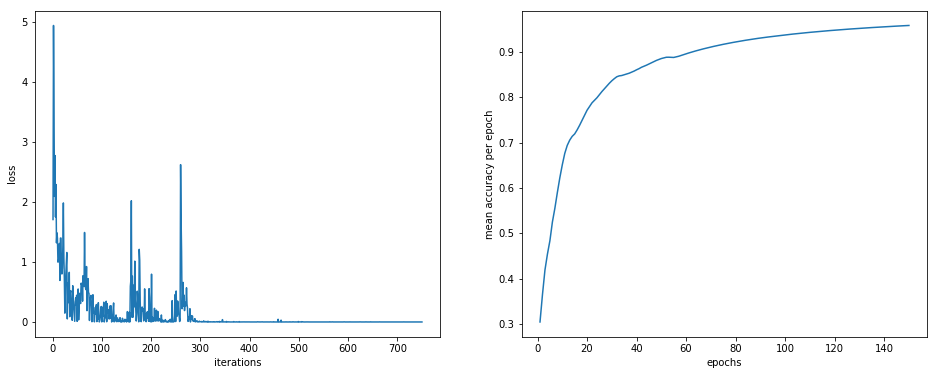

In [27]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(np.arange(1,global_iteration+1), loss_vec)
plt.ylabel('loss')
plt.xlabel('iterations')

plt.subplot(1,2,2)
plt.plot(np.arange(1,epochs+1), train_acc_mean)
plt.ylabel('mean accuracy per epoch')
plt.xlabel('epochs')

plt.show()

## Testing

In [28]:
test_accuracy = []
test_predictions_val=[]
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sess.run(tf.local_variables_initializer())
    num_iterations=int(np.ceil(len(X_test_indices)/batch_size))
    index_last_iter=int(((len(X_test_indices)/batch_size)-(len(X_test_indices)//batch_size))*batch_size)
    
    iteration=1
    for (x, y) in get_batches(X_test_indices, Y_test, batch_size):
                   
        if (iteration==1):
            feed = {model.inputs_: x}
            test_state = sess.run(model.cell.zero_state(tf.shape(x)[0], tf.float32))    
                
            feed = {model.inputs_: x,
                   model.labels_: y[:, None],
                   model.keep_prob: 1,
                   model.initial_state: test_state}
              
        elif (iteration==num_iterations):
            new_state=()
            for lstm_layers_index in range(0, lstm_layers):
                c=test_state[lstm_layers_index][0][0:index_last_iter]
                h=test_state[lstm_layers_index][1][0:index_last_iter]
                ch = tf.contrib.rnn.LSTMStateTuple(c, h)  
                new_state=new_state+(ch,)
                
                    
            feed = {model.inputs_: x,
                   model.labels_: y[:, None],
                   model.keep_prob: 1,
                   model.initial_state: new_state}
    
        else:
            feed = {model.inputs_: x,
                   model.labels_: y[:, None],
                   model.keep_prob: 1,
                   model.initial_state: test_state}
            
        test_predictions,test_loss, test_batch_acc,test_batch_acc_op, test_state = sess.run([model.predictions, 
                                                                                             model.loss,
                                                                                   model.acc,model.acc_op, 
                                                                                   model.final_state], 
                                                                feed_dict=feed)
        test_accuracy.append(test_batch_acc_op) 
        test_predictions_val.extend(np.argmax(test_predictions,1))
        
        print("Iteration: {}".format(iteration),
                      "Test loss: {:.3f}".format(test_loss),
                      "Test accuracy: {:.4f}".format(test_batch_acc_op)
                     )
        iteration +=1
        
    print("Test accuracy (mean): {:.3f}".format(np.mean(test_accuracy)))

Iteration: 1 Test loss: 1.659 Test accuracy: 0.8750
Iteration: 2 Test loss: 2.147 Test accuracy: 0.7857
Test accuracy (mean): 0.830


## Expected and predicted emoji of test set

In [29]:
for i in range(len(X_test)):
    print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] 
          + label_to_emoji(test_predictions_val[i]).strip())

Expected emoji:🍴 prediction: I want to eat	🍴
Expected emoji:😞 prediction: he did not answer	😞
Expected emoji:😄 prediction: he got a very nice raise	😄
Expected emoji:😄 prediction: she got me a nice present	😄
Expected emoji:😄 prediction: ha ha ha it was so funny	😄
Expected emoji:😄 prediction: he is a good friend	😄
Expected emoji:😞 prediction: I am upset	😞
Expected emoji:😄 prediction: We had such a lovely dinner tonight	😄
Expected emoji:🍴 prediction: where is the food	🍴
Expected emoji:😄 prediction: Stop making this joke ha ha ha	😄
Expected emoji:⚾ prediction: where is the ball	⚾
Expected emoji:😞 prediction: work is hard	😞
Expected emoji:😞 prediction: This girl is messing with me	😞
Expected emoji:😞 prediction: are you serious😞
Expected emoji:⚾ prediction: Let us go play baseball	⚾
Expected emoji:😞 prediction: This stupid grader is not working 	😞
Expected emoji:😞 prediction: work is horrible	😞
Expected emoji:😄 prediction: Congratulation for having a baby	❤️
Expected emoji:😞 prediction: stop